# Using G-Mixup To Help Your Model Train

Authors: Anthony Maltsev, Mingyang Wang

In this notebook, we will demonstrate how to use G-Mixup with PyG to create synthetic data that will help a GNN for graph classification generalize better. 

Our example will use the Reddit Binary dataset that is a common benchmark for graph classification tasks. We will begin by training a baseline model without data augmentation, and then we will compare against a model with the same architecture that was trained with an augmented dataset.

In [1]:
# all necessary imports
import numpy as np
import networkx as nx
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.data import GMixupDataset
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_mean_pool
from torch_geometric.utils import to_dense_adj, to_networkx, from_networkx

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

## A Baseline Model

Load in the REDDIT-BINARY dataset and add a dummy uniform node feature vector to all nodes in all graphs in the dataset since the original dataset does not have node features.

In [2]:
def add_dummy_feature(data):
    # If data.x does not exist or data.num_features == 0, create a dummy feature
    if data.x is None or data.num_node_features == 0:
        data.x = torch.ones((data.num_nodes, 1), dtype=torch.float)
    return data

reddit = TUDataset(root='data', name='REDDIT-BINARY', transform=add_dummy_feature)

Now, split the dataset into a training and validation dataset and create corresponding data loaders.

In [3]:
reddit = reddit.shuffle()

train_num = int(len(reddit) * 0.7)
valid_num = int(len(reddit) * 0.9)
train_dataset = reddit[:train_num]
truncated_train_dataset = train_dataset[:int(len(train_dataset) * 0.05)]
val_dataset = reddit[train_num:valid_num]
test_dataset = reddit[valid_num:]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
truncated_train_loader = DataLoader(truncated_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

Define the model architecture for the model that we are going to train. We are using a 5 layer GIN with pre- and post-processing layers that then passes through a few fully connected linear layers to generate graph-level class predictions.

In [4]:
class MyGIN(torch.nn.Module) :
    """
    A 5 layer GIN model for binary classification
    """
    def __init__(self, in_channels=1, num_hidden=32):
        super(MyGIN, self).__init__()

        nn1 = Sequential(Linear(in_channels, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(num_hidden)

        nn2 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(num_hidden)

        nn3 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(num_hidden)

        nn4 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(num_hidden)

        nn5 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(num_hidden)
        
        nn6 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv6 = GINConv(nn6)
        self.bn6 = torch.nn.BatchNorm1d(num_hidden)
        
        nn7 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv7 = GINConv(nn7)
        self.bn7 = torch.nn.BatchNorm1d(num_hidden)
        
        nn8 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv8 = GINConv(nn8)
        self.bn8 = torch.nn.BatchNorm1d(num_hidden)
        
        nn9 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv9 = GINConv(nn9)
        self.bn9 = torch.nn.BatchNorm1d(num_hidden)
        
        nn10 = Sequential(Linear(num_hidden, num_hidden), ReLU(), Linear(num_hidden, num_hidden))
        self.conv10 = GINConv(nn10)
        self.bn10 = torch.nn.BatchNorm1d(num_hidden)

        self.fc1 = Linear(num_hidden, num_hidden)
        self.fc2 = Linear(num_hidden, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index) + x)
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index) + x)
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index) + x)
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index) + x)
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index) + x)
        x = self.bn5(x)
        x = F.relu(self.conv6(x, edge_index) + x)
        x = self.bn6(x)
        x = F.relu(self.conv7(x, edge_index) + x)
        x = self.bn7(x)
        x = F.relu(self.conv8(x, edge_index) + x)
        x = self.bn8(x)
        x = F.relu(self.conv9(x, edge_index) + x)
        x = self.bn9(x)
        x = F.relu(self.conv10(x, edge_index) + x)
        x = self.bn10(x)
                   
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.sigmoid(x)

Instantiate the model.

In [5]:
model = MyGIN(in_channels=reddit.num_node_features, num_hidden=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Define training and validation functions and the loss used in them. 

In [6]:
loss_fn = torch.nn.BCELoss(reduction='sum')

def train(model, train_loader, optimizer) :
    model.train()
    correct = 0
    total = 0
    cum_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch).float().flatten()
        y = data.y.float()
        # print(f"\nout: {output}", f"y:   {y}", sep="\n")
        
        loss = loss_fn(output, y)
        # print(f"loss: {loss.item()}")
        loss.backward()
        optimizer.step()
        
        pred = (output >= 0.5).int()
        # print(f"pred: {pred}")
        correct += pred.eq(y).sum().item()
        total += data.num_graphs
        cum_loss += loss.item()
    acc = correct / total
    loss = loss / total
    return model, acc, loss

def validate(model, val_loader) :
    model.eval()
    correct = 0
    total = 0
    cum_loss = 0
    for data in val_loader :
        output = model(data.x, data.edge_index, data.batch).float().flatten()
        pred = (output >= 0.5).int()
        y = data.y.float()
        cum_loss += loss_fn(output, y).item()
        # print(f"\nout:  {output.flatten()}", f"pred: {pred.flatten()}", f"y:    {y.flatten()}", sep="\n\n")
        # for i in range(len(pred)) :
        #     if pred[i] == y[i] :
        #         print(f"    prediction {pred[i]} from output probability {output[i]} matches target {y[i]}")
        #     else :
        #         print(f"*   prediction {pred[i]} from output probability {output[i]} matches target {y[i]}")
        correct += pred.eq(y).sum().item()
        total += data.num_graphs
    acc = correct / total
    cum_loss = cum_loss / total
    return acc, cum_loss


In [7]:
num_epochs = 75
###
train_accs = []
train_losses = []
val_accs = []
val_losses = []
for i in range(num_epochs) : # epochs
#     model, train_acc, train_loss = train(model, train_loader, optimizer)
      model, train_acc, train_loss = train(model, truncated_train_loader, optimizer)
      val_acc, val_loss = validate(model, val_loader)
      print(f"Epoch {i+1}:", f"Training Accuracy: {train_acc}", f"Training Loss: {train_loss}", \
            f"Validation Accuracy: {val_acc}", f"Validation Loss: {val_loss}", sep="\n   ")
      train_accs.append(train_acc)
      train_losses.append(train_loss)
      val_accs.append(val_acc)
      val_losses.append(val_loss)
    

Epoch 1:
   Training Accuracy: 0.4857142857142857
   Training Loss: 0.05996421352028847
   Validation Accuracy: 0.615
   Validation Loss: 7.570205817222595
Epoch 2:
   Training Accuracy: 0.5857142857142857
   Training Loss: 0.06431711465120316
   Validation Accuracy: 0.7125
   Validation Loss: 1.0929502272605895
Epoch 3:
   Training Accuracy: 0.5857142857142857
   Training Loss: 0.05935996025800705
   Validation Accuracy: 0.6275
   Validation Loss: 0.6530449199676513
Epoch 4:
   Training Accuracy: 0.5428571428571428
   Training Loss: 0.05536927655339241
   Validation Accuracy: 0.61
   Validation Loss: 0.6415911841392518
Epoch 5:
   Training Accuracy: 0.6285714285714286
   Training Loss: 0.05950072035193443
   Validation Accuracy: 0.6575
   Validation Loss: 0.7915851068496704
Epoch 6:
   Training Accuracy: 0.5428571428571428
   Training Loss: 0.05726146697998047
   Validation Accuracy: 0.6675
   Validation Loss: 0.779965763092041
Epoch 7:
   Training Accuracy: 0.6142857142857143
   Trai

Now that we have a trained model, we will evaluate the performance of this base model on the test set that we set aside at the beginning.

In [8]:
test_pred = []
for data in test_loader: 
    test_pred += model(data.x, data.edge_index, data.batch).float().flatten().tolist()
test_y = test_dataset.y.tolist()

AUROC: 0.6765422077922079


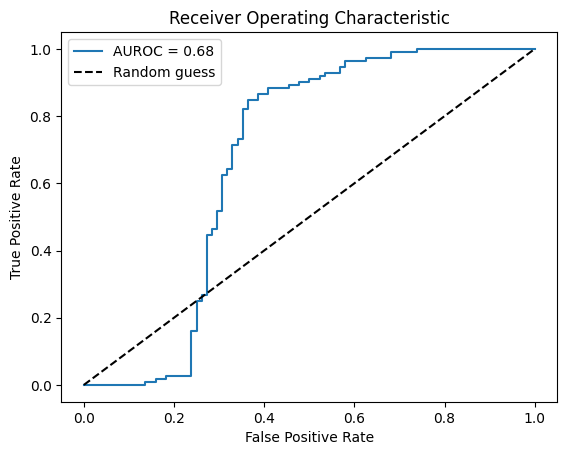

In [9]:
auc = roc_auc_score(test_y, test_pred)
print(f"AUROC: {auc}")

fpr, tpr, thresholds = roc_curve(test_y, test_pred)
plt.figure()
plt.plot(fpr, tpr, label=f'AUROC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

## Enhance the training with G-Mixup

We have seen that a baseline model already performs pretty well on the REDDIT-BINARY dataset. Let's see if we can improve the model performance by training on a dataset that includes some synthetic graphs that were generated using G-Mixup.

We first create some synthetic data and combine it with the original training dataset to create an augmented training data set.

In [10]:
# reddit_gmixup = GMixupDataset(train_dataset, sample_num=50)
reddit_gmixup = GMixupDataset(truncated_train_dataset, sample_num=50)

Generating graphons for 2 classes...

Generating graphon for class 0 with 34 graphs...


100%|██████████| 34/34 [00:45<00:00,  1.35s/it]


Graphon for class 0 generated.
graphon avg = 0.00018110487144440413, original avg = 0.00017232751997653395. These should be close.

Generating graphon for class 1 with 36 graphs...


100%|██████████| 36/36 [00:03<00:00,  9.21it/s]

Graphon for class 1 generated.
graphon avg = 0.0006629180279560387, original avg = 0.0005758744082413614. These should be close.



In [11]:
id0 = 0
id1 = 1
lambdas = [0.2, 0.25, 0.3, 0.7, 0.75, 0.8]
# lambdas =[0, 1]
size = 50
##
synthetic_graphs = []
for lamb in lambdas :
    curr_batch =  reddit_gmixup.generate_graphs(idx_1=id0, idx_2=id1, mixing_param=lamb, K=500, method='random', size=size)
    label = 0 * lamb + 1 * (1 - lamb)
    for g in curr_batch: # shape output graphs to be like real graphs
        g.y = torch.tensor([label])
        g = add_dummy_feature(g)
        g.weight = None
    synthetic_graphs += curr_batch

Generating 50 synthetic graph(s) for indices 0 and 1 with mixing parameter 0.2 and 500 nodes...
Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synthetic graph(s) generated.

Synth

In [12]:
aug_training_dataset = train_dataset + synthetic_graphs
aug_training_loader = DataLoader(aug_training_dataset, batch_size=32, shuffle=True)

In [13]:
# for g in aug_training_dataset :
#     print(g)

Now that we have an augmented training dataset that has some synthetic data generated by G-Mixup, let's define a model and train it on this dataset.

In [14]:
model_gmixup = MyGIN(in_channels=train_dataset.num_node_features, num_hidden=32)
optimizer_gmixup = torch.optim.Adam(model_gmixup.parameters(), lr=0.01)

In [15]:
train_accs_gmixup = []
train_losses_gmixup = []
true_train_accs_gmixup = []
true_train_losses_gmixup = []
val_accs_gmixup = []
val_losses_gmixup = []
for i in range(num_epochs) : # epochs
#     model_gmixup, train_acc, train_loss = train(model_gmixup, aug_training_loader, optimizer_gmixup)
      model_gmixup, train_acc, train_loss = train(model_gmixup, truncated_train_loader, optimizer_gmixup)
      true_train_acc, true_train_loss = validate(model_gmixup, train_loader)
      val_acc, val_loss = validate(model_gmixup, val_loader)
      print(f"Epoch {i+1}:", f"Training Accuracy: {train_acc}", f"Training Loss: {train_loss}", \
            f"True Training Accuracy: {true_train_acc}", f"True Training Loss: {true_train_loss}", \
            f"Validation Accuracy: {val_acc}", f"Validation Loss: {val_loss}", sep="\n   ")
      train_accs_gmixup.append(train_acc)
      train_losses_gmixup.append(train_loss)
      true_train_accs_gmixup.append(true_train_acc)
      true_train_losses_gmixup.append(true_train_loss)
      val_accs_gmixup.append(val_acc)
      val_losses_gmixup.append(val_loss)

Epoch 1:
   Training Accuracy: 0.5428571428571428
   Training Loss: 0.05667269602417946
   True Training Accuracy: 0.735
   True Training Loss: 4.411799042565482
   Validation Accuracy: 0.7425
   Validation Loss: 4.383920154571533
Epoch 2:
   Training Accuracy: 0.6285714285714286
   Training Loss: 0.048342056572437286
   True Training Accuracy: 0.7135714285714285
   True Training Loss: 4.833780941282
   Validation Accuracy: 0.7125
   Validation Loss: 5.105944366455078
Epoch 3:
   Training Accuracy: 0.5857142857142857
   Training Loss: 0.05315320938825607
   True Training Accuracy: 0.6364285714285715
   True Training Loss: 1.749896766117641
   Validation Accuracy: 0.6075
   Validation Loss: 0.8675712609291076
Epoch 4:
   Training Accuracy: 0.5571428571428572
   Training Loss: 0.08382858335971832
   True Training Accuracy: 0.6771428571428572
   True Training Loss: 2.359411848613194
   Validation Accuracy: 0.64
   Validation Loss: 1.4679594588279725
Epoch 5:
   Training Accuracy: 0.614285

In [16]:
test_pred_gmixup = []
for data in test_loader: 
    test_pred_gmixup += model_gmixup(data.x, data.edge_index, data.batch).float().flatten().tolist()
test_y_gmixup = test_dataset.y.tolist()
auc_gmixup = roc_auc_score(test_y_gmixup, test_pred_gmixup)
print(f"AUROC: {auc_gmixup}")

AUROC: 0.8314732142857142


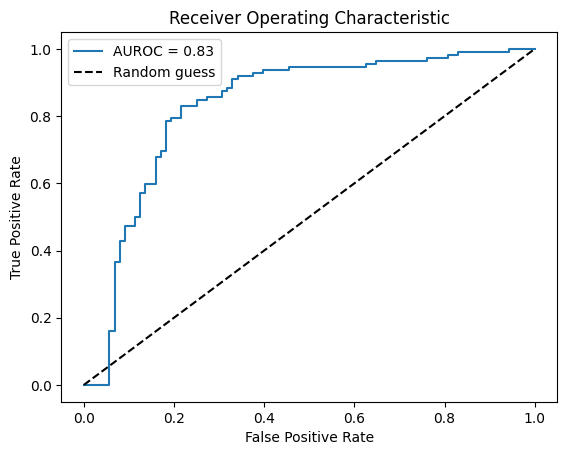

In [17]:
fpr_gmixup, tpr_gmixup, thresholds_gmixup = roc_curve(test_y_gmixup, test_pred_gmixup)
plt.figure()
plt.plot(fpr_gmixup, tpr_gmixup, label=f'AUROC = {auc_gmixup:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()